In [1]:
# Libraries

# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#PyTorch
import torch
import torch.nn as nn
from torch import optim
import torchvision
from torchvision import transforms, models
torch.manual_seed(1)
import torch.nn.functional as F

# data augmentation library
import albumentations as A
from albumentations.pytorch import ToTensorV2

### utilities
# tool to print a nice summary of a network, similary to keras' summary
from torchsummary import summary

# library to do bash-like wildcard expansion
import glob

# others
import pandas as pd
import time
import numpy as np
import random
import os
from sklearn.metrics import classification_report
from PIL import Image
import cv2
from IPython.display import display
from tqdm import tqdm_notebook
import time # To get execution time
import copy # To copy later our best model

from numba import cuda

In [2]:
path = "C:/Users/benji/Pictures/COVID-19_Radiography_Dataset/"     
dirs = ["Normal/images/","COVID/images/","Lung_Opacity/images/","Viral Pneumonia/images/"]

classes = ("Normal","covid ","Lung_opacity","Viral Pneumonia") 

nbClasses = len(classes)

SIZE = 256 # Used size for image's transformations
BATCH_SIZE = 20#210 # env. 1/100
Len = 21165
validation_split = 0.1# Percentage of validation data

normalize = transforms.Normalize(
    mean=[0.509],
    std=[0.229]
)
# Moyenne et écart type des intensités des images reshape en 75,75

def display_tensor(t):
      trans = transforms.ToPILImage()

invNorm = transforms.Normalize(( -0.509/0.229 ),( 1/0.229))
def displayTensorNorm(t):
    trans = transforms.ToPILImage()
    display(trans(invNorm(t)))

## Chargement des données

In [3]:
NORMAL= pd.read_excel('Normal.metadata.xlsx')
NORMAL["Labels"] = 0
NORMAL = NORMAL.drop(['URL', 'SIZE','FORMAT'], axis=1)

COVID= pd.read_excel('COVID.metadata.xlsx')
COVID["Labels"] = 1
COVID = COVID.drop(['URL', 'SIZE','FORMAT'], axis=1)

LUNG= pd.read_excel('Lung_Opacity.metadata.xlsx')
LUNG["Labels"] = 2
LUNG = LUNG.drop(['URL', 'SIZE','FORMAT'], axis=1)

VIRAL= pd.read_excel('Viral Pneumonia.metadata.xlsx')
VIRAL["Labels"] = 3
VIRAL = VIRAL.drop(['URL', 'SIZE','FORMAT'], axis=1)

DF = pd.concat([NORMAL,COVID,LUNG,VIRAL])
DF = DF.reset_index()
DF = DF.drop(['index'], axis=1)

In [4]:
# The class that allows us to handle the data
# We can access each image transform to tensor with its class
class Dataset(torch.utils.data.Dataset):
  
    def __init__(self, dirNames, transform):

        super(Dataset, self).__init__()
        
        # Store the filenames and labels
        self.samples, self.labels = np.array([],dtype=int), np.array([],dtype=int)
        
        # Maybe not optimum, but do the job,
        # we stock labels here to avoid longer epoch later
        if not isinstance(dirNames, list):
            dirNames = dirNames
        i=0 
        for dirName in dirNames:
            print("Chargement de : ", dirName)
                   
            for _, _, filenames in os.walk(dirName):
                cpt = 0             
                for filename in filenames:
                    
                    if (cpt < 500):
                    
                        a= np.longlong(DF.iloc[i,1])
                        self.samples = np.append(self.samples,dirName+filename)
                        self.labels = np.append(self.labels,int(a))    
                        
                    i+=1
                    cpt+=1

                        
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def classesLen(self):
        unique, counts = np.unique(self.labels, return_counts=True)
        return unique, counts

    def __getitem__(self,i):
        img = Image.open(self.samples[i])

        # Return the image with the sample label or ID
        return self.transform(img), self.labels[i]
        #return self.transform(img).repeat(3,1,1), self.labels[i]
#Remise en 3 dimension pour les modèles pre entrainé

In [5]:
print("Initializing Datasets and Dataloaders...")

dataTransforms = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((256, 256)),
    
        transforms.ToTensor(),
        normalize,
        
    ])

trainData = Dataset(dirs,dataTransforms)

print("Nb of data : " + str(len(trainData)))


Initializing Datasets and Dataloaders...
Chargement de :  Normal/images/
Chargement de :  COVID/images/
Chargement de :  Lung_Opacity/images/
Chargement de :  Viral Pneumonia/images/
Nb of data : 2000


In [7]:
N_val_samples = round(validation_split * len(trainData))


cd_train_set, cd_val_set = torch.utils.data.random_split(trainData, [len(trainData) - 
                                                                     N_val_samples, N_val_samples])


In [8]:
cd_train_dl = torch.utils.data.DataLoader(cd_train_set, batch_size=BATCH_SIZE, num_workers=0)
cd_val_dl = torch.utils.data.DataLoader(cd_val_set, batch_size=BATCH_SIZE, num_workers=0)

## Model

In [9]:
net = torchvision.models.resnext101_32x8d(pretrained=False)

C:\Users\benji\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\benji\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)
net.conv1 = new_conv

In [ ]:
in_features = net.fc.in_features
features = list(net.fc.children())[:-1]
features.extend([nn.Linear(in_features,4),nn.LogSoftmax(dim=1)])
net.fc = nn.Sequential(*features)

## Trainning

In [12]:
net = net.cuda()

LEARNING_RATE = 0.003
MOMENTUM = 0.9

criterion = nn.NLLLoss()

# Méthode stochastique de descente du grandient 
optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [13]:
epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []

In [14]:
## Nombre d'époque d'apprentissage
N_EPOCHS = 25

start_time = time.time()

for e in range(N_EPOCHS):
  
    print("EPOCH:",e)
    
    ### boucle d'entraineement
    running_loss = 0
    running_accuracy = 0
    running_acc=0
    start_epoch_time=time.time()

    ## Le réseau est mis en mode "entrainement"
    net.train()

    for i, batch in enumerate(cd_train_dl):
        
        # Obtenir batch du dataloader
        x = batch[0]
        labels = batch[1]

        # déplacer le batch sur le GPU
        x = x.cuda()

        labels = labels.type(torch.LongTensor) 
        
        labels = labels.cuda()

        # Calcul de l'output et les loss
        output = net(x)
        y = output
        
        loss = criterion(y, labels)

        # Réinitialisation du gradients
        optimizer.zero_grad()

        # Calculs du gradients
        loss.backward()

        # Appliquecation d'une étape d'optimisation de l'algorithme de descente pour mettre à jour les poids
        optimizer.step()

        with torch.no_grad():
            running_loss += loss.item()

            running_accuracy += (y.max(1)[1] == labels).sum().item()
            

    print("Training accuracy:", running_accuracy/float(len(trainData) -validation_split * len(trainData)),
        "Training loss:", running_loss/float( len(trainData) -validation_split * len(trainData)))

    epoch_loss.append(running_loss/(len(trainData) -validation_split * len(trainData)))
    epoch_acc.append(running_accuracy/(len(trainData) -validation_split * len(trainData)))

    ### Boucle de valisation
    ## Le réseau est mis en mode validation
    net.eval()

    running_val_loss = 0
    running_val_accuracy = 0
    vv=vf=fv=ff=0
    vx=vw=fx=fw=0
    xv=xf=xx=xw=0
    wv=wf=wx=ww=0
    for i, batch in enumerate(cd_val_dl):
    
        with torch.no_grad():
            
            x = batch[0]
            labels = batch[1]
            
            x = x.cuda()
            labels = labels.type(torch.LongTensor) 
            labels = labels.cuda()
            
            output = net(x)
            y = output

            loss = criterion(y, labels)

            running_val_loss += loss.item()
            running_val_accuracy += (y.max(1)[1] == labels).sum().item()
            ################################
            for i in range(len(labels)):
                if labels[i].item() == 0:
                    if y.max(1)[1][i].item() == 0:
                        vv += 1
                    elif y.max(1)[1][i].item() == 1:
                        vf += 1
                    elif y.max(1)[1][i].item() == 2:
                        vx += 1
                    else:
                        vw += 1
                elif labels[i].item() == 1:
                    if y.max(1)[1][i].item() == 0:
                        fv += 1
                    elif y.max(1)[1][i].item() == 1:
                        ff += 1
                    elif y.max(1)[1][i].item() == 2:
                        fx += 1
                    else:
                        fw += 1
                elif labels[i].item() == 2:
                    if y.max(1)[1][i].item() == 0:
                        xv += 1
                    elif y.max(1)[1][i].item() == 1:
                        xf += 1
                    elif y.max(1)[1][i].item() == 2:
                        xx += 1
                    else:
                        xw += 1
                else:
                    if y.max(1)[1][i].item() == 0:
                        wv += 1
                    elif y.max(1)[1][i].item() == 1:
                        wf += 1
                    elif y.max(1)[1][i].item() == 2:
                        wx += 1
                    else:
                        ww += 1      

    
    print("Validation accuracy:", running_val_accuracy/float(validation_split * len(trainData)),
        "Validation loss:", running_val_loss/float(validation_split * len(trainData)))
    

    print("predict |","  0   |","  1  |","   2   |","  3 ")
    print(" Réel   ---------------------------------")
    print("class 0 | ",vv,"  | ",vf," | ",vx,"  | ",vw)
    print("class 1 | ",fv,"  | ",ff," | ",fx,"  | ",fw)
    print("class 2 | ",xv,"  | ",xf," | ",xx,"  | ",xw)
    print("class 3 | ",wv,"  |  ",wf,"  |  ",wx,"   | ",ww)

    epoch_val_loss.append(running_val_loss/(validation_split * len(trainData)))
                          
    epoch_val_acc.append(running_val_accuracy/(validation_split * len(trainData)))
    
    inter = time.time() - start_epoch_time  
    print ('Temps de l Epoch ',e,' en secondes:', inter )
    

interval = time.time() - start_time  
print ('Temps total en secondes:', interval )


EPOCH: 0
Training accuracy: 0.3705555555555556 Training loss: 0.08061728656291961
Validation accuracy: 0.43 Validation loss: 0.07464520454406738
predict |   0   |   1  |    2   |   3 
 Réel   ---------------------------------
class 0 |  40   |  0  |  10   |  0
class 1 |  22   |  1  |  32   |  0
class 2 |  8   |  0  |  45   |  0
class 3 |  34   |   1   |   7    |  0
Temps de l Epoch  0  en secondes: 115.0404601097107
EPOCH: 1
Training accuracy: 0.64 Training loss: 0.049937532974614035
Validation accuracy: 0.67 Validation loss: 0.041946720778942105
predict |   0   |   1  |    2   |   3 
 Réel   ---------------------------------
class 0 |  41   |  2  |  6   |  1
class 1 |  9   |  32  |  14   |  0
class 2 |  8   |  2  |  43   |  0
class 3 |  18   |   2   |   4    |  18
Temps de l Epoch  1  en secondes: 110.0443708896637
EPOCH: 2
Training accuracy: 0.7266666666666667 Training loss: 0.03974270252717866
Validation accuracy: 0.785 Validation loss: 0.03027098372578621
predict |   0   |   1  |  

Training accuracy: 0.9955555555555555 Training loss: 0.0007599919623377597
Validation accuracy: 0.875 Validation loss: 0.03232055872678757
predict |   0   |   1  |    2   |   3 
 Réel   ---------------------------------
class 0 |  43   |  2  |  4   |  1
class 1 |  4   |  46  |  5   |  0
class 2 |  4   |  2  |  47   |  0
class 3 |  2   |   1   |   0    |  39
Temps de l Epoch  20  en secondes: 115.21247243881226
EPOCH: 21
Training accuracy: 0.9983333333333333 Training loss: 0.00030825936065310896
Validation accuracy: 0.885 Validation loss: 0.031565796360373495
predict |   0   |   1  |    2   |   3 
 Réel   ---------------------------------
class 0 |  44   |  3  |  2   |  1
class 1 |  5   |  47  |  3   |  0
class 2 |  4   |  3  |  46   |  0
class 3 |  1   |   1   |   0    |  40
Temps de l Epoch  21  en secondes: 115.48468947410583
EPOCH: 22
Training accuracy: 0.9972222222222222 Training loss: 0.0005410669090492269
Validation accuracy: 0.9 Validation loss: 0.030223454758524896
predict |   

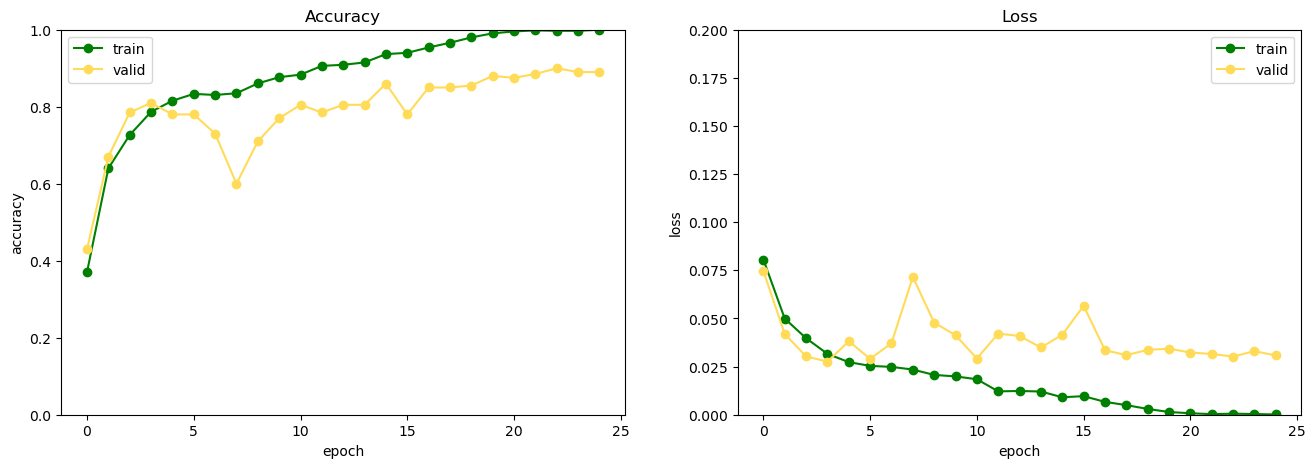

In [19]:
# Courbes d'accuracy et de perte
plt.figure(figsize = (16,5))

plt.subplot(121)
plt.plot(epoch_acc, color="green", marker="o", label="train")
plt.plot(epoch_val_acc, color="#FFDB58", marker="o", label="valid")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.ylim(0,1)
plt.legend()
plt.title("Accuracy")

plt.subplot(122)
plt.plot(epoch_loss, color="green", marker="o", label="train")
plt.plot(epoch_val_loss,  color="#FFDB58", marker="o", label="valid")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(0,.2)
plt.title("Loss")
plt.legend()
plt.show();

### Sauvegarde

In [20]:
torch.save(net.state_dict(), 'resnet_model.pth')


In [12]:
net.load_state_dict(torch.load('resnet_model.pth'))

<All keys matched successfully>

## Chargement du datatest

In [13]:
# The class that allows us to handle the data
# We can access each image transform to tensor with its class
class Dataset(torch.utils.data.Dataset):
  
    def __init__(self, dirNames, transform):

        super(Dataset, self).__init__()
        
        # Store the filenames and labels
        self.samples, self.labels = np.array([],dtype=int), np.array([],dtype=int)
        
        # Maybe not optimum, but do the job,
        # we stock labels here to avoid longer epoch later
        if not isinstance(dirNames, list):
            dirNames = dirNames
        i=0 
        for dirName in dirNames:
            print("Chargement de : ", dirName)
                   
            for _, _, filenames in os.walk(dirName):
                cpt = 0             
                for filename in filenames:
                    
                    if (cpt > 399):
                        if(cpt < 500):
                    
                            a= np.longlong(DF.iloc[i,1])

                            self.samples = np.append(self.samples,dirName+filename)
                            self.labels = np.append(self.labels,int(a))       
                    i+=1
                    cpt+=1
                        
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def classesLen(self):
        unique, counts = np.unique(self.labels, return_counts=True)
        return unique, counts

    def __getitem__(self,i):
        img = Image.open(self.samples[i])

        # Return the image with the sample label or ID
        return self.transform(img), self.labels[i]
        #return self.transform(img).repeat(3,1,1), self.labels[i]
#Remise en 3 dimension pour les modèles pre entrainé

In [14]:
print("Initializing Datasets test and Dataloaders test...")

testData = Dataset(dirs,dataTransforms)

print("Nb of data : " + str(len(testData)))

Initializing Datasets test and Dataloaders test...
Chargement de :  Normal/images/
Chargement de :  COVID/images/
Chargement de :  Lung_Opacity/images/
Chargement de :  Viral Pneumonia/images/
Nb of data : 400


## Prédiction

In [16]:
eval_dl = torch.utils.data.DataLoader(testData,batch_size=1,num_workers=0)

In [17]:
def confusion_matrix():
    net.cuda()
    net.eval()

    right_count = np.zeros((4))
    total = np.zeros((4))
    confusion_matrix = np.zeros((4,4))

    for i, batch in enumerate(eval_dl):

      with torch.no_grad():
        x = batch[0]
        label = batch[1]

        x = x.cuda()

        y = net(x)
        out_put = y.max(1)[1].tolist()
        labels = label.tolist()
        
        for i in range(len(labels)):
            confusion_matrix[labels[i]][out_put[i]] += 1
    return confusion_matrix

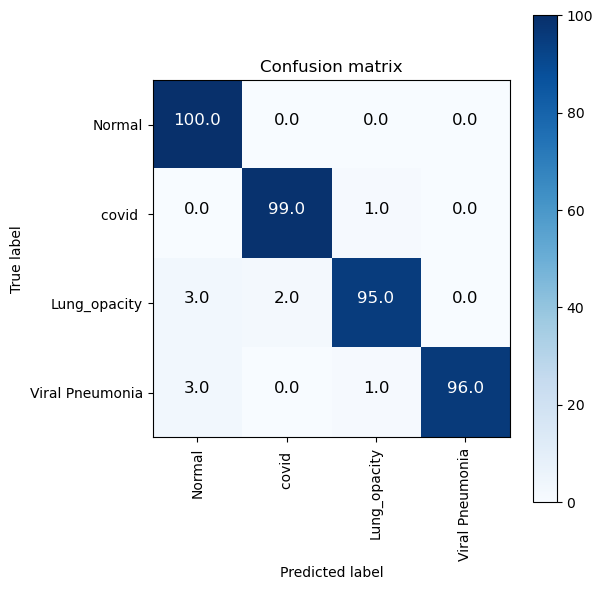

In [18]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#get confusion matrix
cm = confusion_matrix()
#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [29]:
def Accuracy():
    net.cuda()
    net.eval()
    acc=0
    
    y_true = []
    y_pred = []
    
    for i, batch in enumerate(eval_dl):

      with torch.no_grad():
        x = batch[0]
        label = batch[1]

        x = x.cuda()

        y = net(x)
        out_put = y.max(1)[1].tolist()
        labels = label.tolist()
        
        for i in range(len(labels)):
            y_true.append(labels[i])
            y_pred.append(out_put[i])
            if (labels[i] == out_put[i]):
                acc+=1

    print(classification_report(y_true, y_pred, target_names=classes))
    
    return acc/400

In [30]:
print("L'accuracy du modèle resnet101 sur les images masquées est de {:.2f}%".format(Accuracy(), 2))

                 precision    recall  f1-score   support

         Normal       0.94      1.00      0.97       100
         covid        0.98      0.99      0.99       100
   Lung_opacity       0.98      0.95      0.96       100
Viral Pneumonia       1.00      0.96      0.98       100

       accuracy                           0.97       400
      macro avg       0.98      0.97      0.98       400
   weighted avg       0.98      0.97      0.98       400

L'accuracy du modèle resnet101 sur les images masquées est de 0.97%
